In [1]:
%matplotlib inline
import os
import sys
import tarfile
import pickle
import matplotlib.pyplot as plt
import numpy as np, h5py 
import pandas as pd
from PIL import Image
import tensorflow as tf
import cv2

In [2]:
os.getcwd()

'/home/ubuntu'

In [3]:
pickle_file = 'SVHN.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_train = save['train_dataset']
    y_train = save['train_labels']
    X_val = save['valid_dataset']
    y_val = save['valid_labels']
    X_test = save['test_dataset']
    y_test = save['test_labels']
    del save  
    print('Training data shape:', X_train.shape)
    print('Training label shape:',y_train.shape)
    print('Validation data shape:', X_val.shape)
    print('Validation label shape:', y_val.shape)
    print('Test data shape:', X_test.shape)
    print('Test label shape:', y_test.shape)

('Training data shape:', (230070, 32, 32, 1))
('Training label shape:', (230070, 6))
('Validation data shape:', (5684, 32, 32, 1))
('Validation label shape:', (5684, 6))
('Test data shape:', (13068, 32, 32, 1))
('Test label shape:', (13068, 6))


In [6]:
X_test.shape

(13068, 32, 32, 1)

In [9]:
type(X_test[0])

numpy.ndarray

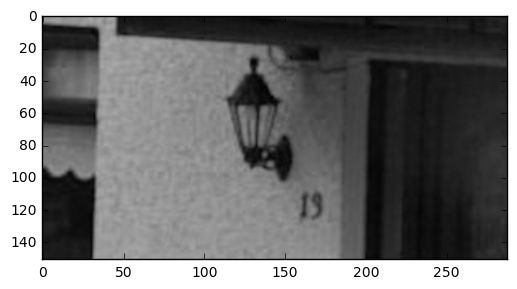

In [25]:
im_test = Image.open('test/13.png').convert('LA')
plt.imshow(im_test)

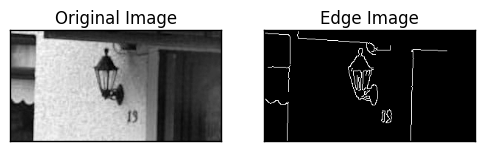

In [29]:
img = cv2.imread('test/13.png',0)
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

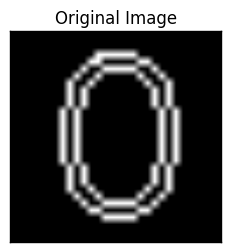

In [59]:
img_gray_0 = np.zeros((30,30), np.uint8)
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img_gray_0,'0',(5,25), font, 1,(255,255,255),1,cv2.LINE_AA)
#plt.imshow(img_0,cmap = 'gray')
template_0 = cv2.Canny(img_gray_0,100,200)
plt.subplot(121),plt.imshow(template_0,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([]);

In [73]:
loc[0].shape

(0,)

Len 2
(array([], dtype=int64), array([], dtype=int64))


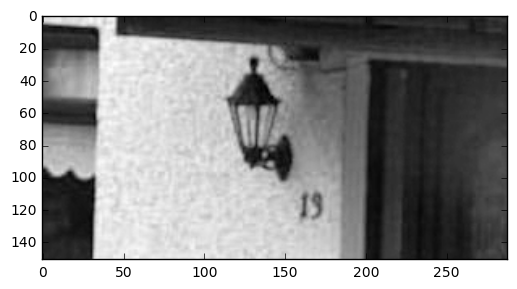

In [66]:
w, h = template_0.shape[::-1]
res = cv2.matchTemplate(img,template_0,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
print('Len '+str(len(loc)))
print(loc)
for pt in zip(*loc[::-1]):
    print('Pt '+str(pt))
    cv2.rectangle(img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
plt.imshow(img,cmap = 'gray')
#cv2.imwrite('res.png',img_rgb)

In [4]:
def accuracy(predictions, labels):
    print('Predictions shape '+str(predictions.shape))
    print(r'Predictions[0] ' + str(predictions[0]))
    print('Predictions argmax '+str(np.argmax(predictions, 2).T[0]))
    print('Labels '+str(labels))
    print('Labels shape '+str(labels.shape))
    return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] / predictions.shape[0])

In [5]:
image_size = 32
num_channels = 1
batch_size = 16
num_labels = 11
patch_size = 5
depth_1 = 16
depth_2 = depth_1 * 2
depth_3 = depth_2 * 3
# Number of hidden nodes in fully connected layer 1
num_hidden = 64
shape = [batch_size, image_size, image_size, num_channels]

In [13]:
graph = tf.Graph()
with graph.as_default():
    # X_train: (223965, 32, 32, 1)
    #                                                    (16,        32,          32,        1)
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    # y_train: (223965, 7)
    #                                                (16,         6)
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
    # X_val: (11788, 32, 32, 1)
    
    tf_valid_dataset = tf.constant(X_val)
    # X_test: (13067, 32, 32, 1)
    tf_test_dataset = tf.constant(X_test)
    
    # Create Variables Function
    def init_weights(shape, name):
        return tf.Variable(tf.random_normal(shape=shape, stddev=0.01),name=name)
    
    def init_biases(shape, name):
        return tf.Variable(tf.constant(1.0, shape=shape),name=name)
    
    def output_size_pool(input_size, conv_filter_size, pool_filter_size, padding, conv_stride, pool_stride):
        if padding == 'same':
            padding = -1.00
        elif padding == 'valid':
            padding = 0.00
        else:
            return None
        # After convolution 1
        output_1 = (((input_size - conv_filter_size - 2 * padding) / conv_stride) + 1.00)
        print('output_1 = '+ str(output_1))
        # After pool 1
        output_2 = (((output_1 - pool_filter_size - 2 * padding) / pool_stride) + 1.00)
        print('output_2 = '+str(output_2))
        # After convolution 2
        output_3 = (((output_2 - conv_filter_size - 2 * padding) / conv_stride) + 1.00)
        print('output_3 = '+str(output_3))
        # After pool 2
        output_4 = (((output_3 - pool_filter_size - 2 * padding) / pool_stride) + 1.00)
        print('output_4 = '+str(output_4))
        # After convolution 2
        output_5 = (((output_4 - conv_filter_size - 2 * padding) / conv_stride) + 1.00)
        print('output_5 = '+str(output_5))
        # After pool 2
        # output_6 = (
        #     ((output_5 - pool_filter_size - 2 * padding) / pool_stride) + 1.00)
        return int(output_5)
    
    # Convolution 1
    # Input channels: num_channels = 1
    # Output channels: depth = depth_1
    #                  ([5,          5,          1,             16])
    w_c1 = init_weights([patch_size, patch_size, num_channels, depth_1], 'w_c1')
    b_c1 = init_biases([depth_1], 'b_c1')

    # Convolution 2
    # Input channels: num_channels = depth_1
    # Output channels: depth = depth_2
    #                  ([5,          5,          16,      32])
    w_c2 = init_weights([patch_size, patch_size, depth_1, depth_2], 'w_c2')
    #                 ([32])
    b_c2 = init_biases([depth_2], 'b_c2')

    # Convolution 3
    # Input channels: num_channels = depth_2
    # Output channels: depth = depth_3
    #                   ([5,         5,          32,      48])
    w_c3 = init_weights([patch_size, patch_size, depth_2, depth_3], 'w_c3')
    #                 ([48])
    b_c3 = init_biases([depth_3], 'b_c3')
    
    # Fully Connect Layer 1
    #                                   (32,                 )
    final_image_size = output_size_pool(input_size=image_size, conv_filter_size=5, pool_filter_size=2,
                                        padding='valid', conv_stride=1,pool_stride=2)
    print('Final image size after convolutions {}'.format(final_image_size))
    
    #                   ([X*X*48,64])
    w_fc1 = init_weights([final_image_size*final_image_size*depth_3, num_hidden], 'w_fc1')
    #                  ([64])
    b_fc1 = init_biases([num_hidden], 'b_fc1')
    
    # Softmax 1
    #                  ([64,         11])
    w_s1 = init_weights([num_hidden, num_labels], 'w_s1')
    #                  ([11])
    b_s1 = init_biases([num_labels], 'b_s1')
    
    # Softmax 2
    #                  ([64,        11])
    w_s2 = init_weights([num_hidden, num_labels], 'w_s2')
    #                  ([11])
    b_s2 = init_biases([num_labels], 'b_s2')
    
    # Softmax 3
    #                  ([64,        11])
    w_s3 = init_weights([num_hidden, num_labels], 'w_s3')
    #                  ([11])
    b_s3 = init_biases([num_labels], 'b_s3')

    # Softmax 4
    #                  ([64,        11])
    w_s4 = init_weights([num_hidden, num_labels], 'w_s4')
    #                  ([11])
    b_s4 = init_biases([num_labels], 'b_s4')

    # Softmax 5
    #                  ([64,        11])
    w_s5 = init_weights([num_hidden, num_labels], 'w_s5')
    #                  ([11])
    b_s5 = init_biases([num_labels], 'b_s5')
    
    
    
    def model(data, keep_prob, shape):
        with tf.name_scope("conv_layer_1"):
            conv_1 = tf.nn.conv2d(data, w_c1, strides=[1, 1, 1, 1], padding='VALID')
            hidden_conv_1 = tf.nn.relu(conv_1 + b_c1)
            pool_1 = tf.nn.max_pool(hidden_conv_1, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        with tf.name_scope("conv_layer_2"):
            conv_2 = tf.nn.conv2d(pool_1, w_c2, strides=[1, 1, 1, 1], padding='VALID')
            hidden_conv_2 = tf.nn.relu(conv_2 + b_c2)
            pool_2 = tf.nn.max_pool(hidden_conv_2, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        with tf.name_scope("conv_layer_3"):
            conv_3 = tf.nn.conv2d(pool_2, w_c3, strides=[1, 1, 1, 1], padding='VALID')
            hidden_conv_3 = tf.nn.relu(conv_3 + b_c3)
        with tf.name_scope("fc_layer_1"):
            hidden_drop = tf.nn.dropout(hidden_conv_3, keep_prob)
            shape = hidden_drop.get_shape().as_list()
            reshape = tf.reshape(hidden_drop, [shape[0], shape[1] * shape[2] * shape[3]])
            hidden_fc = tf.nn.relu(tf.matmul(reshape, w_fc1) + b_fc1)
        with tf.name_scope("softmax_1"):
            logits_1 = tf.matmul(hidden_fc, w_s1) + b_s1
        with tf.name_scope("softmax_2"):
            logits_2 = tf.matmul(hidden_fc, w_s2) + b_s2
        with tf.name_scope("softmax_3"):
            logits_3 = tf.matmul(hidden_fc, w_s3) + b_s3
        with tf.name_scope("softmax_4"):
            logits_4 = tf.matmul(hidden_fc, w_s4) + b_s4
        with tf.name_scope("softmax_5"):
            logits_5 = tf.matmul(hidden_fc, w_s5) + b_s5
            
        return [logits_1, logits_2, logits_3, logits_4, logits_5]
    
    '''Training Computation'''
    [logits_1, logits_2, logits_3, logits_4, logits_5] = model(tf_train_dataset, 0.5, shape)
    
    with tf.name_scope("loss"):
        loss =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_1, tf_train_labels[:, 1])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_2, tf_train_labels[:, 2])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_3, tf_train_labels[:, 3])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_4, tf_train_labels[:, 4])) + \
                tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits_5, tf_train_labels[:, 5]))
        # Add scalar summary for cost
        tf.scalar_summary("loss", loss)
        
    '''Optimizer'''
    # Decaying learning rate
    # count the number of steps taken
    global_step = tf.Variable(0)
    start_learning_rate = 0.05
    
    learning_rate = tf.train.exponential_decay(start_learning_rate, global_step, 100000, 0.96, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    '''Predictions'''
    def softmax_combine(dataset, shape):
        train_prediction = tf.pack([
            tf.nn.softmax(model(dataset, 1.0, shape)[0]),
            tf.nn.softmax(model(dataset, 1.0, shape)[1]),
            tf.nn.softmax(model(dataset, 1.0, shape)[2]),
            tf.nn.softmax(model(dataset, 1.0, shape)[3]),
            tf.nn.softmax(model(dataset, 1.0, shape)[4])])
        return train_prediction
    
    train_prediction = softmax_combine(tf_train_dataset ,shape)
    valid_prediction = softmax_combine(tf_valid_dataset ,shape)
    test_prediction  = softmax_combine(tf_test_dataset  ,shape)

    '''Save Model (will be initiated later)'''
    saver = tf.train.Saver()
    
    '''Histogram for Weights'''
    # Add histogram summaries for weights
    tf.histogram_summary("w_c1_summ", w_c1)
    tf.histogram_summary("b_c1_summ", b_c1)

    tf.histogram_summary("w_c2_summ", w_c2)
    tf.histogram_summary("b_c2_summ", b_c2)

    tf.histogram_summary("w_c3_summ", w_c3)
    tf.histogram_summary("b_c3_summ", b_c3)

    tf.histogram_summary("w_fc1_summ", w_fc1)
    tf.histogram_summary("b_fc1_summ", b_fc1)

    tf.histogram_summary("w_s1_summ", w_s1)
    tf.histogram_summary("b_s1_summ", b_s1)

    tf.histogram_summary("w_s2_summ", w_s2)
    tf.histogram_summary("b_s2_summ", b_s2)

    tf.histogram_summary("w_s3_summ", w_s3)
    tf.histogram_summary("b_s3_summ", b_s3)

    tf.histogram_summary("w_s4_summ", w_s4)
    tf.histogram_summary("b_s4_summ", b_s4)

    tf.histogram_summary("w_s5_summ", w_s5)
    tf.histogram_summary("b_s5_summ", b_s5)
    
print('Data loaded and computation graph built!')
num_steps = 60000

with tf.Session(graph=graph) as session:
    writer = tf.train.SummaryWriter("~/log_trial_1", session.graph)  # for 0.8
    merged = tf.merge_all_summaries()

    '''If you want to restore model'''
    # saver.restore(session, "model_trial_1.ckpt")
    # print("Model restored!")

    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions, summary = session.run([optimizer, loss, train_prediction, merged],feed_dict=feed_dict)
        writer.add_summary(summary)
        if (step % 500 == 0):
            print(('Minibatch loss at step {}: {}').format(step, l))
            print(('Minibatch accuracy: {}%'.format(accuracy(predictions, batch_labels[:,1:6]))))
            print(('Validation accuracy: {}%'.format(accuracy(valid_prediction.eval(),y_val[:,1:6]))))
    print(('Test accuracy: {}%'.format(accuracy(test_prediction.eval(), y_test[:,1:6]))))

    save_path = saver.save(session, "model_trial_1.ckpt")
    print('Model saved in file: {}'.format(save_path))


print('Successfully completed computation and iterations!')

print('To view Tensorboard\'s visualizations, please run tensorboard --logdir=log_trial_1 in your terminal')

output_1 = 28.0
output_2 = 14.0
output_3 = 10.0
output_4 = 5.0
output_5 = 1.0
Final image size after convolutions 1
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histogram uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on their scope.
Instructions for updating:
Please switch to tf.summary.histogram. Note that tf.summary.histog